In [104]:
import unidecode
import string
import random
import re
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from fastDamerauLevenshtein import damerauLevenshtein

In [119]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('data.txt').read())
file_len = len(file)
print('file_len =', file_len)
all_characters

file_len = 1592


'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [106]:
data_split = file.splitlines()

In [107]:
file2 = file.replace('\n','')
file2

'pocgkrcgwpcfkskfsfkspwgpfkswkfsococgwptgkfsocpwfkgpowcercoprerkwopofkkskfopwpwgcocpocrfksfkscgpogpocpwocgfkfsrereocwgrkwpgsfkpwofsgpocpocwgkfspocgwgpwgockfsfksretocpwgfkskfsrerecopwgwpreskpwterfkfpocwggpfkfksrerwpofcgkrpwgfksocrcwpfksorpwfksorcpocgwkfkfserpowctgcogpowgcpopwfktpwokfkrgcopcogpgwfksrpgsfkskfgwgptocopwgpowcgreperkscwgtfpcgworkfkfspopocgkrpwtgcfkfksrpocwkfpgkfkfcwopgpowcgkfkfrwpgfkskpocwcpoerepwkfcptgopocfkswgrpowcfkfkpwgfksfkgpwfkscgwpwcwopgtrekfksksfpocsfkwocpwgfkfpwgterkfsocpocgwrkfstgcwpropocgkfskfrpgcowopwgwpgcowpcfksrereptwgfkspocrfkfkpockrpockfskfswgretgpcowpgpwcoggwpfrkstpfkfksgpwogsfkgpwkfgwpocoskfsfkwtpcockfkfwpgfkfkrepococwtrfkfkgpwocfksfksrpwgerkspoctfkfkrwgpwfksocrtnpzctnpcztnpzctnzpcpmzxmbzdpImzmzxppbzpgzpnzgadnzgdppndznzpdgdsmcddxppcfkdddaagdagpkpcgkfadppfgdsbcsfgkappbsfkcgapbgafkcsgpbcksfapbfkscgapbsgkafcpbcskfgapsfkagcbpfkscagbpfskagcbpskfcagbpfkscagbpsfkgacbpfkbscgapcgafkbsgpabkfscpabkgcfsgcpabkfspasbkfgcpabcgksfsfkpcgabspgbkfcaspakgfcbcgbkpasffkspcbagpkf

In [118]:
all_chars = ''.join(set(sorted(file2)))
all_chars

'nbomstrhwakxgdpIzfce'

In [109]:
chunk_len = 300

In [110]:
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

In [111]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [112]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

In [113]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [114]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [115]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [116]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len

In [151]:
evaluate('0', 1, temperature=0.4)

'0a'

### Prequential method

In [129]:
n_epochs = 300
print_every = 50
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('po', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 8s (50 16%) 2.0599]
pocra
pocowgfkf
ptscgabk
pwsfks
pkfsrerereeo
wgwhwgpocr
pwgfk
te
ptngcg
poow
poc
pocpwgc
pocopoefkscgk 

 17s (100 33%) 1.2915]
pocwter
powckfkr
pogwpoc
pocwkfk
pocwrkf
ptomockf
pwgfk
cspkfkab
pfgsksb
fscgab
psfkgbca
pkfsagbc
pkfs 

 26s (150 50%) 0.7203]
pockfk
pwkfk
pocwfksg
pwfksoc
pocrkfs
pocre
tnpz
pocworkfkf
pocwkf
gwpwfksr
pocwfkfkskf
wpgfksfkrc
poc 

 35s (200 66%) 0.8910]
poc
pabkgcfs
gcpasbkf
pabgkfcsa
cpkfbga
cbkfsga
pbfkgcsa
pbskfgca
pbsgca
cpkfsbga
cpkbfsga
cpkfsbagc
p 

 44s (250 83%) 0.4312]
pocgk
pwtgcfkfksr
pocwfk
gpocwgfksr
pocfkswgr
pwgerks
pockfkfsrere
pocwcfkfsrer
wptocrfkfks
pockre
ptf 

 53s (300 100%) 0.3444]
poc
pwocgkfskfsrere
wpocfkskfsrere
copwcr
wpocfksfksr
ptwgo
pocfkswgr
pocwkf
pgkfkf
cwopg
pwocgkfkfr
w 



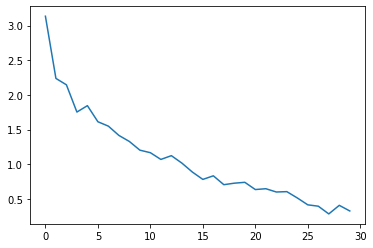

In [130]:
plt.figure()
plt.plot(all_losses)

In [131]:
results = [[] for line in data_split]
errors = [[] for x in data_split]

for line in range(0, len(data_split)):
    i = 1
    
    while i < len(data_split[line]):
        #if i == 0:
        #    first_char = evaluate('', 1, temperature=0.4)
        #    predicted = first_char[1]
        #    observed = data_split[line][i]
        #    error = 1 - damerauLevenshtein(predicted, observed)
        #    errors[line].append(error)
        #    i += 1
        #else:
            # generate prediction for next char (input: current char)
        next_char = evaluate(data_split[line][i-1], 1, temperature=0.4)
        predicted = next_char[1]
        observed = data_split[line][i]
            # compare predicted to observed
        #print(predicted, observed)
        error = 1 - damerauLevenshtein(predicted, observed)
        
        errors[line].append(error)
        i += 1

In [132]:
errors

[[1.0, 0.0, 0.0, 1.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [1.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0],
 [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.

In [133]:
summed_error = [sum(error) for error in errors]
np.median(summed_error)

5.0